### Bitcoin network analysis during late 2013 price bubble
We analyse the weighted directed bitcoin transaction network of transactional data from 09-sep-2013 until 08-dec-2013. Direction represents the flow of bitcoin, and the weights represent the amount of bitcoin the transaction contains.

Because of the size of the total network, we analyse the strong and weakly connected components of the network. By doing this, we significantly decrease the size of the network, allowing for faster calculation of metrics relevant for the analysis.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import itertools
import random
import os
import sys
import pickle
import powerlaw
import pyintergraph as interG
import numpy as np

from pythonlouvain import community
from statistics import mean

In [2]:
%matplotlib inline
sns.set()

In [3]:
# import data filenames
BIT_PATH = 'bitcoin_data/'
bitcoin_filenames = sorted([f for f in os.listdir(BIT_PATH) if not f.startswith('.')])
total_weeks = len(bitcoin_filenames)

#### Structural network metrics

We start with building the dataframe which contains all the structural network metrics we want to calculate. This is done by loading in the weekly networks one by one, calculating the metrics for a week, and adding the metrics of one week to the dataframe.

We build two dataframes: One for the strongly connected component and one for the weakly connected component.

In [4]:
def average_degree(degree_list):
    """Calculates the average degree of a network"""    
    
    average_degree = sum(list(map(lambda x: x[1], degree_list))) / len(degree_list)
    return average_degree

def degree_distribution(degree_list):
    """Calculates the degree distribution of a network"""
    
    degree_frequency = {}
    degrees = [x[1] for x in degree_list]
    for degree in degrees:
        if degree in degree_frequency:
            degree_frequency[degree] += 1
        else:
            degree_frequency[degree] = 1
            
    return degree_frequency

def centrality_distribution(centrality_dict):
    """Calculates the centrality distribution of a network"""
    centrality_frequency = {}
    centralities = list(centrality_dict.values())
    for centrality in centralities:
        rounded_centrality = round(centrality, 7)
        if rounded_centrality in centrality_frequency:
            centrality_frequency[rounded_centrality] += 1
        else:
            centrality_frequency[rounded_centrality] = 1
            
    return centrality_frequency

def shortest_path_sampling(network, n_samples):
    """Calculates a shortest path approximation by sampling n times"""
    
    nodes = network.nodes()
    path_lengths = []
    
    for i in range(n_samples):
        # get random node pair and calculate shortest path length between nodes
        n1, n2 = random.choices(list(nodes), k=2)
        path_length = nx.shortest_path_length(network, source=n1, target=n2)
        path_lengths.append(path_length)
        
    # calculate average of 
    average_shortest_path_approx = mean(path_lengths)
    
    return average_shortest_path_approx

def bit_metrics(network, strong_bool):
    """returns a dictionary with the network metrics of a week"""
    week_metrics = {}
    
    # set all metrics for one week
    week_metrics['amount of nodes'] = network.number_of_nodes()
    week_metrics['amount of edges'] = network.number_of_edges()
    week_metrics['density'] = nx.density(network)
    week_metrics['clustering'] = nx.average_clustering(network)
    week_metrics['average in degrees'] = average_degree(network.in_degree())
    week_metrics['average out degrees'] = average_degree(network.out_degree())
    week_metrics['average total degrees'] = average_degree(network.degree())
    if strong_bool == True:    
        week_metrics['average shortest path'] = shortest_path_sampling(network, 10000) # approximation by sampling
    else:
        week_metrics['average shortest path'] = shortest_path_sampling(network.to_undirected(), 10000) # approximation by sampling
    week_metrics['diameter'] = nx.approximation.diameter(network.to_undirected()) # approximation
    week_metrics['in degree distribution'] = [degree_distribution(network.in_degree())]
    week_metrics['out degree distribution'] = [degree_distribution(network.out_degree())]
    week_metrics['total degree distribution'] = [degree_distribution(network.degree())]
    week_metrics['centrality distribution'] = [centrality_distribution(nx.betweenness_centrality(network, k=100))] # approximation  
    
    return week_metrics

In [5]:
# load in bitcoin network and extract strong/weak components of one week

def load_files(file_name):

    G = nx.read_graphml(os.path.join(BIT_PATH, file_name))

    largest_strong_nodes = max(nx.strongly_connected_components(G), key=len)
    largest_weak_nodes = max(nx.weakly_connected_components(G), key=len)    
    
    largest_strong_network = nx.DiGraph(G.subgraph(largest_strong_nodes))
    largest_weak_network = nx.DiGraph(G.subgraph(largest_weak_nodes))
    
    return largest_strong_network, largest_weak_network

In [6]:
# build dataframe with metrics of all weeks

def build_bit_df():
    
    for i, bit_file_name in enumerate(bitcoin_filenames):
        strong, weak = load_files(bit_file_name)
        print(f'loaded file {bit_file_name} ({i+1}/{len(bitcoin_filenames)})')
        if i == 0:
            strong_metric_df = pd.DataFrame()
            weak_metric_df = pd.DataFrame()
            
        strong_metrics = bit_metrics(strong, True)
        weak_metrics = bit_metrics(weak, False)
        
        strong_metric_df = strong_metric_df.append(strong_metrics, ignore_index=True)
        weak_metric_df = weak_metric_df.append(weak_metrics, ignore_index=True)
        print(f'finished new strong metrics of {bit_file_name}')
        
    return strong_metric_df, weak_metric_df

def add_week_numbers(df):
    # add week number as a column
    df = df.reset_index()
    df['index'] += 1
    df = df.rename(columns = {'index': 'week'})

    return df

The following cell will build the desired dataframes using above code. Because of the large size of the networks, these computations are very time consuming. Therefore, after computing them once, the dataframes will be pickled and stored on disk. After this, you can unpickle the dataframes in the future to avoid having to re-calculate all network metrics everytime you wish to run analysis on the dataframes.

In [7]:
# call build function to generate the entire dataframes
strong_df, weak_df = build_bit_df()

# add week number columns to both dataframes
strong_df = add_week_numbers(strong_df)
weak_df = add_week_numbers(weak_df)

print("strong component dataframe")
display(strong_df)

print("weak component dataframe")
display(weak_df)

loaded file 2013-09-09_to_2013-09-15.graphml (1/13)
finished new strong metrics of 2013-09-09_to_2013-09-15.graphml
loaded file 2013-09-16_to_2013-09-22.graphml (2/13)
finished new strong metrics of 2013-09-16_to_2013-09-22.graphml
loaded file 2013-09-23_to_2013-09-29.graphml (3/13)
finished new strong metrics of 2013-09-23_to_2013-09-29.graphml
loaded file 2013-09-30_to_2013-10-06.graphml (4/13)
finished new strong metrics of 2013-09-30_to_2013-10-06.graphml
loaded file 2013-10-07_to_2013-10-13.graphml (5/13)
finished new strong metrics of 2013-10-07_to_2013-10-13.graphml
loaded file 2013-10-14_to_2013-10-20.graphml (6/13)
finished new strong metrics of 2013-10-14_to_2013-10-20.graphml
loaded file 2013-10-21_to_2013-10-27.graphml (7/13)
finished new strong metrics of 2013-10-21_to_2013-10-27.graphml
loaded file 2013-10-28_to_2013-11-03.graphml (8/13)
finished new strong metrics of 2013-10-28_to_2013-11-03.graphml
loaded file 2013-11-04_to_2013-11-10.graphml (9/13)
finished new strong 

,week,amount of nodes,amount of edges,density,clustering,average in degrees,average out degrees,average total degrees,average shortest path,diameter,in degree distribution,out degree distribution,total degree distribution,centrality distribution
0,1,59574.0,148959.0,0.000042,0.163906,2.500403,2.500403,5.000806,7.5082,13.0,"[{1: 30709, 3: 4135, 12: 65, 29021: 1, 800: 1,...","[{4: 1988, 6: 522, 2: 25913, 3: 11427, 1: 1783...","[{5: 7704, 7: 1451, 3: 16715, 6: 2643, 2: 1277...","[{0.0001431: 2, 9.27e-05: 2, 1.68e-05: 6464, 0..."
1,2,60774.0,153809.0,0.000042,0.162316,2.530836,2.530836,5.061671,7.5111,13.0,"[{3: 4026, 1: 30861, 5: 814, 68: 1, 29778: 1, ...","[{2: 26113, 3: 12004, 6: 524, 15198: 1, 801: 1...","[{5: 8006, 4: 15700, 8: 1036, 3: 16217, 70: 1,...","[{3.29e-05: 2897, 1.65e-05: 6547, 8.19e-05: 9,..."
2,3,60619.0,153914.0,0.000042,0.174404,2.539039,2.539039,5.078078,6.8625,10.0,"[{1: 31966, 31086: 1, 115: 1, 4: 1625, 42: 4, ...","[{1: 18913, 15965: 1, 32: 5, 4: 1990, 3: 11437...","[{2: 13334, 47051: 1, 147: 1, 8: 946, 4: 14886...","[{0.0: 26659, 0.9929702: 1, 0.0011757: 1, 1.65..."
3,4,65944.0,166822.0,0.000038,0.153345,2.529753,2.529753,5.059505,7.8154,12.0,"[{2: 24632, 30185: 1, 55: 2, 6: 555, 4: 1971, ...","[{10: 75, 15972: 1, 3: 13652, 16: 13, 4: 2226,...","[{12: 242, 46157: 1, 58: 3, 9: 644, 20: 40, 24...","[{1.52e-05: 7081, 0.995739: 1, 0.0: 27150, 2.0..."
4,5,64295.0,163760.0,0.000040,0.162871,2.547010,2.547010,5.094020,9.6808,19.0,"[{1: 33302, 3: 4510, 2: 21490, 4: 1843, 30048:...","[{3: 12255, 2: 26609, 16136: 1, 1: 20246, 8: 1...","[{4: 15438, 6: 2874, 3: 17266, 46184: 1, 2: 14...","[{7.8e-06: 1238, 5.13e-05: 5, 2.07e-05: 244, 1..."
5,6,69933.0,176285.0,0.000036,0.165067,2.520770,2.520770,5.041540,9.0291,11.0,"[{33142: 1, 7: 385, 3: 4595, 1: 37185, 2: 2275...","[{19229: 1, 5: 979, 4: 2299, 1: 23920, 3: 1223...","[{52371: 1, 12: 251, 7: 1734, 2: 17677, 6: 300...","[{0.9966782: 1, 1.43e-05: 8146, 0.0: 29470, 0...."
6,7,80556.0,214668.0,0.000033,0.171103,2.664829,2.664829,5.329659,8.2453,23.0,"[{17: 40, 2: 30248, 1: 36519, 63: 2, 38376: 1,...","[{43: 5, 5: 1281, 2: 34124, 3: 16407, 1: 23566...","[{60: 4, 7: 2487, 3: 19934, 5: 11270, 64: 2, 6...","[{0.0006818: 2, 2.38e-05: 21, 0.0: 35461, 1.24..."
7,8,71727.0,185615.0,0.000036,0.158704,2.587798,2.587798,5.175596,8.0067,10.0,"[{20: 18, 1: 33250, 4: 2138, 2: 27526, 33397: ...","[{51: 3, 4: 2398, 6: 669, 2: 30705, 9: 105, 1:...","[{71: 3, 5: 9657, 10: 464, 3: 18327, 11: 379, ...","[{0.0008308: 1, 0.0: 30326, 7.7e-05: 6, 1.39e-..."
8,9,97739.0,259483.0,0.000027,0.157465,2.654856,2.654856,5.309713,7.8978,22.0,"[{13: 106, 43200: 1, 1: 42951, 5: 1855, 2: 373...","[{53: 9, 24946: 1, 3: 19975, 1: 29791, 2: 3935...","[{66: 2, 68146: 1, 4: 25076, 2: 19505, 3: 2321...","[{0.0010082: 1, 0.997347: 1, 0.0: 43333, 9.35e..."
9,10,96291.0,257001.0,0.000028,0.152520,2.669003,2.669003,5.338007,8.3075,39.0,"[{2: 36532, 3: 8608, 1: 42093, 34: 11, 6: 1038...","[{2: 37833, 1: 29593, 5: 1809, 3: 19819, 4: 42...","[{4: 25162, 5: 13677, 2: 19207, 3: 22058, 35: ...","[{4.2e-06: 115, 0.0: 42757, 2.08e-05: 4205, 3...."


weak component dataframe


,week,amount of nodes,amount of edges,density,clustering,average in degrees,average out degrees,average total degrees,average shortest path,diameter,in degree distribution,out degree distribution,total degree distribution,centrality distribution
0,1,102971.0,227312.0,0.000021,0.114752,2.207534,2.207534,4.415068,3.2086,23.0,"[{1: 50967, 2: 26182, 3: 5898, 4: 2942, 12: 14...","[{4: 2685, 6: 710, 2: 32973, 3: 14032, 1: 2569...","[{5: 9747, 7: 2135, 4: 17964, 2: 17695, 43: 15...","[{6.3e-05: 2, 4.08e-05: 5, 7.4e-06: 8233, 0.0:..."
1,2,104007.0,242400.0,0.000022,0.116856,2.330612,2.330612,4.661225,3.4182,50.0,"[{3: 6056, 1: 54699, 6: 959, 76: 1, 0: 7295, 2...","[{2: 33055, 3: 14961, 1: 21752, 6: 781, 23729:...","[{5: 10139, 4: 19238, 9: 876, 3: 20415, 78: 6,...","[{1.35e-05: 3544, 6.7e-06: 8465, 4.02e-05: 12,..."
2,3,104933.0,246041.0,0.000022,0.121982,2.344744,2.344744,4.689488,3.1918,20.0,"[{1: 56308, 38207: 1, 0: 7436, 2: 26128, 3: 60...","[{1: 22324, 25329: 1, 2: 31644, 3: 14707, 0: 2...","[{2: 18913, 63536: 1, 4: 17964, 3: 20950, 1: 2...","[{0.0: 67525, 0.5924821: 1, 0.0005419: 1, 7e-0..."
3,4,112431.0,270152.0,0.000021,0.111434,2.402825,2.402825,4.805650,3.2970,18.0,"[{2: 30845, 38130: 1, 92: 4, 1: 56308, 7: 766,...","[{12: 83, 26331: 1, 4: 3339, 1: 22542, 0: 2898...","[{14: 290, 64461: 1, 96: 5, 3: 21700, 1: 24891...","[{0.0012027: 1, 0.5530798: 1, 3.39e-05: 9, 6.1..."
4,5,111155.0,263767.0,0.000021,0.117625,2.372966,2.372966,4.745931,3.2934,24.0,"[{1: 58577, 3: 6764, 2: 27920, 10: 300, 37752:...","[{3: 15651, 2: 37752, 25901: 1, 1: 21203, 8: 2...","[{4: 20116, 6: 3971, 12: 433, 3: 25156, 63653:...","[{3.2e-06: 1298, 2.14e-05: 15, 8.6e-06: 303, 6..."
5,6,130706.0,302436.0,0.000018,0.108987,2.313865,2.313865,4.627729,6.8589,85.0,"[{0: 10177, 42406: 1, 1: 73633, 7: 896, 6: 124...","[{2: 42903, 30316: 1, 5: 1420, 4: 3368, 1: 252...","[{2: 20552, 72722: 1, 3: 28561, 12: 448, 10: 8...","[{0.0: 85991, 0.5243764: 1, 5.4e-06: 10812, 7...."
6,7,136606.0,330010.0,0.000018,0.122053,2.415780,2.415780,4.831559,3.2874,30.0,"[{19: 101, 2: 37101, 1: 65064, 0: 12210, 63: 5...","[{46: 5, 5: 1776, 2: 44148, 3: 19468, 1: 29761...","[{65: 5, 7: 3546, 3: 25220, 5: 13593, 1: 30594...","[{0.0003012: 2, 1e-05: 49, 0.0: 87173, 5.2e-06..."
7,8,131312.0,308159.0,0.000018,0.110815,2.346770,2.346770,4.693539,3.3661,28.0,"[{27: 64, 1: 65451, 4: 3717, 2: 35606, 42660: ...","[{54: 4, 4: 3601, 0: 38666, 7: 372, 2: 40130, ...","[{81: 6, 5: 12433, 1: 32598, 11: 589, 3: 23627...","[{0.0003438: 2, 0.0: 85349, 2.89e-05: 138, 1.0..."
8,9,178399.0,418585.0,0.000013,0.105403,2.346342,2.346342,4.692683,3.5056,23.0,"[{19: 111, 57203: 1, 1: 84780, 2: 48473, 11: 3...","[{59: 9, 39105: 1, 3: 24298, 1: 39058, 4: 5593...","[{78: 6, 96308: 1, 4: 32000, 2: 31166, 5: 1752...","[{0.0004486: 1, 0.5468584: 1, 0.0: 116279, 3.8..."
9,10,185999.0,447948.0,0.000013,0.101211,2.408336,2.408336,4.816671,3.4744,39.0,"[{26: 56, 2: 48794, 1: 89335, 0: 16539, 56958:...","[{78: 8, 2: 51646, 1: 39273, 41846: 1, 3: 2438...","[{104: 4, 4: 32545, 3: 29012, 2: 31674, 1: 496...","[{0.0005679: 1, 0.0: 123946, 0.5051563: 1, 3.4..."


#### Distribution parameters

Once the dataframe with metrics and distributions of each network is obtained, we add the distribution parameters of the degree and centrality distributions. To do so, we fit a power law to each distribution and extract the lambda parameter (power) of the obtained power law. The obtained values for each network are added to the dataframe.

In [8]:
def distribution_lambda(distribution_dict):
    '''
    This function calculates the relevant distribution parameters. It extends functionality from
    the "powerlaw" library.

    input: any distribution dictionary with key value pairs as {metric(float): frequency(int)}
    ------------
    output: dict with relevant distribution metrics {max_degree: value, lambda_in: value, lambda_out: value}
    '''
    
    dict_sorted = dict(sorted(distribution_dict.items()))

    # get list of frequencies
    frequencies = list(dict_sorted.values())

    old_stdout = sys.stdout # These sys lines avoid prints included in the powerlaw library
    sys.stdout = open(os.devnull, "w")
     
    # fit powerlaw on list of frequencies
    fit= powerlaw.Fit(frequencies)
    lambda_param = fit.power_law.alpha
    sys.stdout = old_stdout
    
    rounded_lambda = round(lambda_param, 3)
    return rounded_lambda

def add_degree_parameters(df, row):
    in_distribution = df.iloc[row]['in degree distribution'][0]
    out_distribution = df.iloc[row]['out degree distribution'][0]
    tot_distribution = df.iloc[row]['total degree distribution'][0]

    # get lambdas
    lambda_in = distribution_lambda(in_distribution)
    lambda_out = distribution_lambda(out_distribution)
    
    # get max degree
    max_degree = max(list(tot_distribution.keys()))

    distribution_params = {'max degree': max_degree, 'lambda in': lambda_in, 'lambda out':lambda_out}

    df.at[row, 'degree distribution parameters'] = distribution_params

    return 

def add_centrality_lambda(df, row):
    centrality_distribution = df.iloc[row]['centrality distribution'][0]
    lambda_centrality = distribution_lambda(centrality_distribution)
    df.at[row, 'centrality distribution lambda'] = lambda_centrality

    return

In [9]:
# initialise empty distribution parameter columns
strong_df['degree distribution parameters'] = ""
strong_df['centrality distribution lambda'] = ""
weak_df['degree distribution parameters'] = ""
weak_df['centrality distribution lambda'] = ""

# calculate distribution parameters and add them to the dataframes
for row in list(strong_df.index.values):
    add_degree_parameters(strong_df, row)
    add_centrality_lambda(strong_df, row)
for row in list(weak_df.index.values):
    add_degree_parameters(weak_df, row)
    add_centrality_lambda(weak_df, row)

# dataframes are pickled to be used later on for further calcs on the metrics
strong_pickle = strong_df.to_pickle(f'bitcoin_pickle/strong_dataframe_{total_weeks}weeks.pkl')
weak_pickle = weak_df.to_pickle(f'bitcoin_pickle/weak_dataframe_{total_weeks}weeks.pkl')

print('added lambda parameters')

added lambda parameters


In [10]:
# choose the columns to display and display the dataframes
strong_df_display = strong_df[['week', 'amount of nodes', 'amount of edges', 'density', 'clustering', 'average in degrees', 'average out degrees', 'average total degrees', 'average shortest path', 'diameter', 'degree distribution parameters', 'centrality distribution lambda']]
weak_df_display = weak_df[['week', 'amount of nodes', 'amount of edges', 'density', 'clustering', 'average in degrees', 'average out degrees', 'average total degrees', 'average shortest path', 'diameter', 'degree distribution parameters', 'centrality distribution lambda']]
print('Strong component dataframe:')
display(strong_df_display)
print('Weak component dataframe:')
display(weak_df_display)

Strong component dataframe:


,week,amount of nodes,amount of edges,density,clustering,average in degrees,average out degrees,average total degrees,average shortest path,diameter,degree distribution parameters,centrality distribution lambda
0,1,59574.0,148959.0,0.000042,0.163906,2.500403,2.500403,5.000806,7.5082,13.0,"{'max degree': 44285, 'lambda in': 1.625, 'lam...",2.09
1,2,60774.0,153809.0,0.000042,0.162316,2.530836,2.530836,5.061671,7.5111,13.0,"{'max degree': 44976, 'lambda in': 1.418, 'lam...",2.054
2,3,60619.0,153914.0,0.000042,0.174404,2.539039,2.539039,5.078078,6.8625,10.0,"{'max degree': 47051, 'lambda in': 1.406, 'lam...",2.062
3,4,65944.0,166822.0,0.000038,0.153345,2.529753,2.529753,5.059505,7.8154,12.0,"{'max degree': 46157, 'lambda in': 1.394, 'lam...",2.145
4,5,64295.0,163760.0,0.000040,0.162871,2.547010,2.547010,5.094020,9.6808,19.0,"{'max degree': 46184, 'lambda in': 1.408, 'lam...",2.099
5,6,69933.0,176285.0,0.000036,0.165067,2.520770,2.520770,5.041540,9.0291,11.0,"{'max degree': 52371, 'lambda in': 1.43, 'lamb...",1.83
6,7,80556.0,214668.0,0.000033,0.171103,2.664829,2.664829,5.329659,8.2453,23.0,"{'max degree': 60450, 'lambda in': 1.415, 'lam...",2.026
7,8,71727.0,185615.0,0.000036,0.158704,2.587798,2.587798,5.175596,8.0067,10.0,"{'max degree': 51349, 'lambda in': 1.437, 'lam...",2.086
8,9,97739.0,259483.0,0.000027,0.157465,2.654856,2.654856,5.309713,7.8978,22.0,"{'max degree': 68146, 'lambda in': 1.411, 'lam...",2.097
9,10,96291.0,257001.0,0.000028,0.152520,2.669003,2.669003,5.338007,8.3075,39.0,"{'max degree': 67267, 'lambda in': 1.42, 'lamb...",2.1


Weak component dataframe:


,week,amount of nodes,amount of edges,density,clustering,average in degrees,average out degrees,average total degrees,average shortest path,diameter,degree distribution parameters,centrality distribution lambda
0,1,102971.0,227312.0,0.000021,0.114752,2.207534,2.207534,4.415068,3.2086,23.0,"{'max degree': 61498, 'lambda in': 1.529, 'lam...",2.03
1,2,104007.0,242400.0,0.000022,0.116856,2.330612,2.330612,4.661225,3.4182,50.0,"{'max degree': 60692, 'lambda in': 1.363, 'lam...",2.024
2,3,104933.0,246041.0,0.000022,0.121982,2.344744,2.344744,4.689488,3.1918,20.0,"{'max degree': 63536, 'lambda in': 1.474, 'lam...",2.006
3,4,112431.0,270152.0,0.000021,0.111434,2.402825,2.402825,4.805650,3.2970,18.0,"{'max degree': 64461, 'lambda in': 1.439, 'lam...",2.132
4,5,111155.0,263767.0,0.000021,0.117625,2.372966,2.372966,4.745931,3.2934,24.0,"{'max degree': 63653, 'lambda in': 1.398, 'lam...",1.807
5,6,130706.0,302436.0,0.000018,0.108987,2.313865,2.313865,4.627729,6.8589,85.0,"{'max degree': 72722, 'lambda in': 1.46, 'lamb...",2.151
6,7,136606.0,330010.0,0.000018,0.122053,2.415780,2.415780,4.831559,3.2874,30.0,"{'max degree': 81306, 'lambda in': 1.532, 'lam...",1.934
7,8,131312.0,308159.0,0.000018,0.110815,2.346770,2.346770,4.693539,3.3661,28.0,"{'max degree': 72949, 'lambda in': 1.452, 'lam...",2.04
8,9,178399.0,418585.0,0.000013,0.105403,2.346342,2.346342,4.692683,3.5056,23.0,"{'max degree': 96308, 'lambda in': 1.472, 'lam...",2.079
9,10,185999.0,447948.0,0.000013,0.101211,2.408336,2.408336,4.816671,3.4744,39.0,"{'max degree': 98804, 'lambda in': 1.438, 'lam...",2.086


Once the dataframes above are obtained for the desired dataset, you can unpickle the dataframes with the cell below. This will allow for further analysis on the metrics in the dataframe without having to recalculate all the metrics

In [6]:
strong_df = pd.read_pickle('bitcoin_pickle/strong_dataframe_13weeks.pkl')
weak_df = pd.read_pickle('bitcoin_pickle/weak_dataframe_13weeks.pkl')

#### Temporal evolution of metrics

The obtained dataframes can be used to plot the temporal evolution of the calculated metrics. Below function will be called for each metric of which we want to plot the temporal evolution.

In [7]:
def column_combo_plot(column_list, df, dataframe_name):
    
    # select subset of columns to plot
    df = df[df.columns.intersection(['week'] + column_list)]
    
    # convert wide df to long df
    df_melt = df.melt('week', var_name='columns', value_name='values')
    
    plot = sns.catplot(x='week', y='values', hue='columns', data=df_melt, kind='point')
    plt.ylabel(None)
    if dataframe_name == 'strong':
        plt.title("strongly connected component")
    if dataframe_name == 'weak':
        plt.title("weakly connected component")
    
    return

#### Amount of nodes and edges

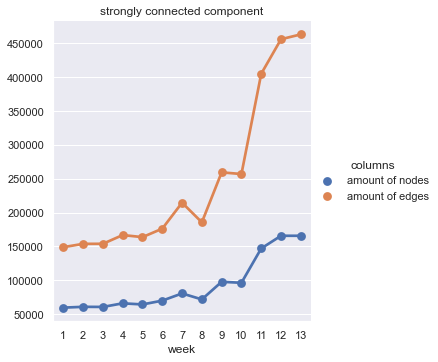

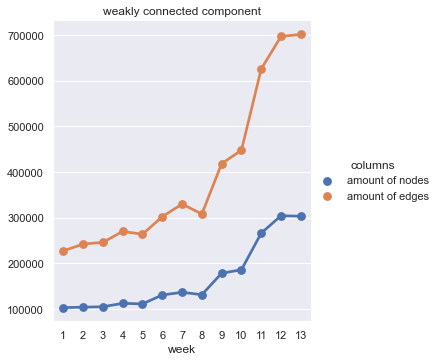

In [8]:
column_combo_plot(['amount of nodes', 'amount of edges'], strong_df, 'strong')
column_combo_plot(['amount of nodes', 'amount of edges'], weak_df, 'weak')

#### Network densities

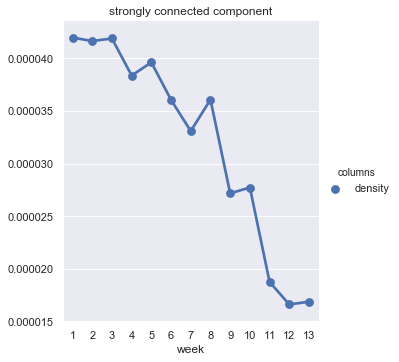

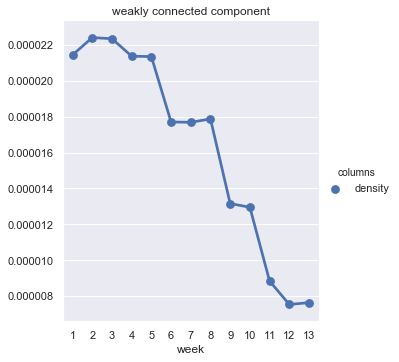

In [13]:
column_combo_plot(['density'], strong_df, 'strong')
column_combo_plot(['density'], weak_df, 'weak')

#### Average clustering

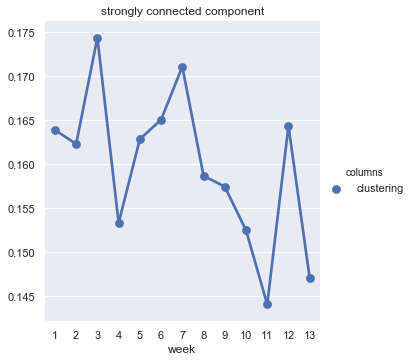

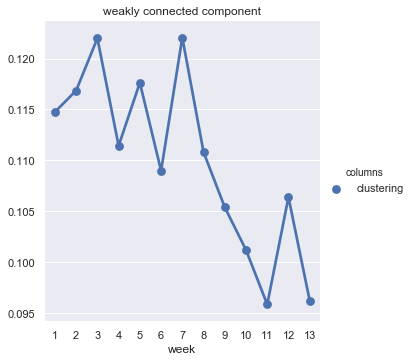

In [14]:
column_combo_plot(['clustering'], strong_df, 'strong')
column_combo_plot(['clustering'], weak_df, 'weak')

#### Average degrees

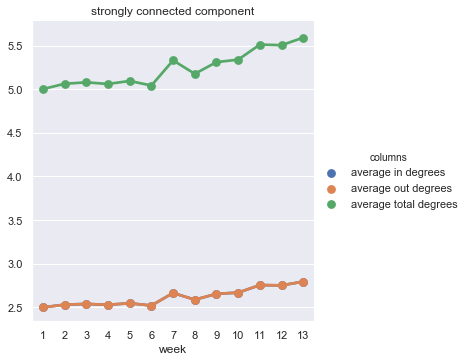

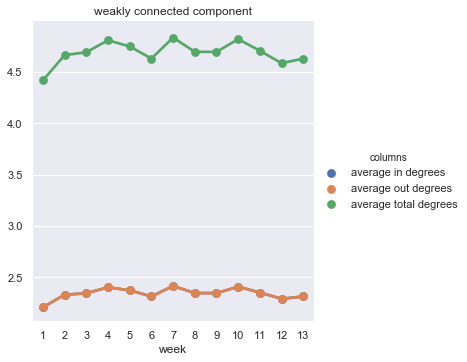

In [15]:
column_combo_plot(['average in degrees', 'average out degrees', 'average total degrees'], strong_df, 'strong')
column_combo_plot(['average in degrees', 'average out degrees', 'average total degrees'], weak_df, 'weak')

#### Average shortest path

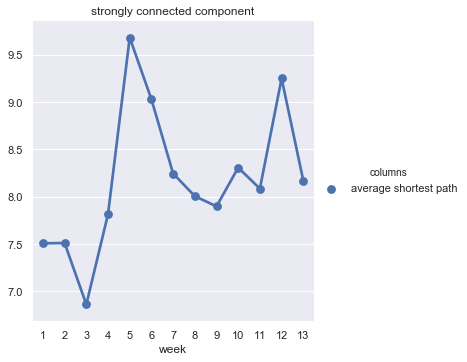

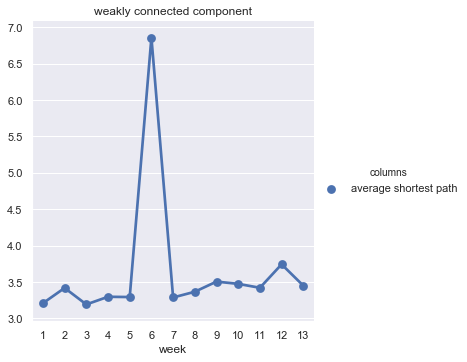

In [16]:
column_combo_plot(['average shortest path'], strong_df, 'strong')
column_combo_plot(['average shortest path'], weak_df, 'weak')

#### Diameter

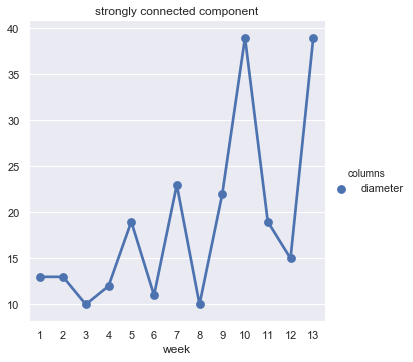

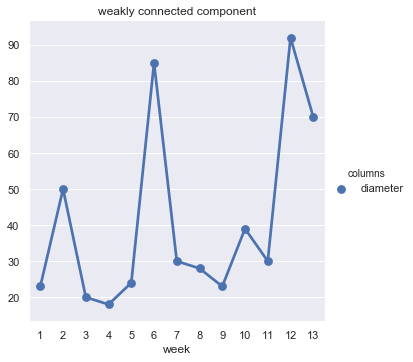

In [17]:
column_combo_plot(['diameter'], strong_df, 'strong')
column_combo_plot(['diameter'], weak_df, 'weak')

#### Degree and centrality distribution plots

In [13]:
# distribution plot
def temporal_distribution(column, df, df_name):
    
    distributions = df[column].tolist()
    xlabel = column.replace(' distribution', '')
    plt.figure()
    
    # extract frequencies out of each distribution dictionary
    for i, distribution in enumerate(distributions):
        distribution = {k: v for k, v in sorted(distribution[0].items(), key=lambda item: item[1], reverse=True)}
        degrees = list(distribution.keys())
        frequencies = list(distribution.values())    
        plt.scatter(degrees, frequencies, label=f'week {i+1}', alpha=0.5)
    if df_name == 'strong':
        plt.title(f'Temporal {column} for the strong component')
        plt.xlabel(xlabel)
        plt.xscale('log')
        plt.yscale('log')    
        plt.ylabel("frequency")
        plt.legend()
    if df_name == 'weak':
        plt.title(f'Temporal {column} for the weak component')
        plt.xlabel(xlabel)
        plt.xscale('log')
        plt.yscale('log')    
        plt.ylabel("frequency")
        plt.legend()
    
    return

# temporal lambda parameter plots
def degree_lambda_plot(df, df_name):
    all_parameters = df['degree distribution parameters'].tolist()
    weeks = df['week'].tolist()
    lambda_in_evolution = [parameters['lambda in'] for parameters in all_parameters]
    lambda_out_evolution = [parameters['lambda out'] for parameters in all_parameters]
    
    plt.figure()
    plt.scatter(weeks, lambda_in_evolution, label='lambda in')
    plt.scatter(weeks, lambda_out_evolution, label='lambda out')
    plt.xlabel('lambda value')
    plt.legend()
    if df_name == 'strong':
        plt.title('evolution of lambda in and lambda out of SCC network')
    if df_name == 'weak':
        plt.title('evolution of lambda in and lambda out of WCC network')
    
    return

def centrality_lambda_plot(df, df_name):
    plt.figure()
    sns.scatterplot(data=df, x='week', y='centrality distribution lambda')
    plt.xticks(df['week'].tolist())
    if df_name == 'strong':
        plt.title('evolution of centrality distribution lambda of SCC network')
    if df_name == 'weak':
        plt.title('evolution of centrality distribution lambda of WCC network')
    
    return
    

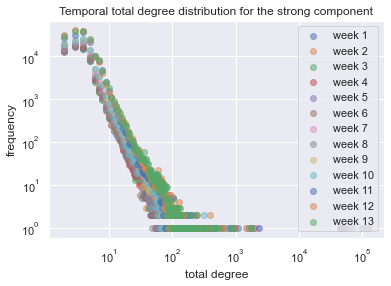

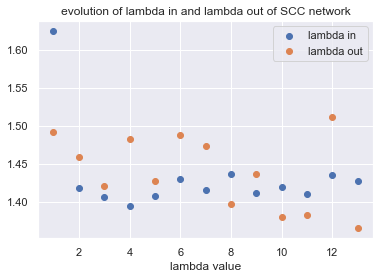

In [10]:
temporal_distribution('total degree distribution', strong_df, 'strong')
degree_lambda_plot(strong_df, 'strong')

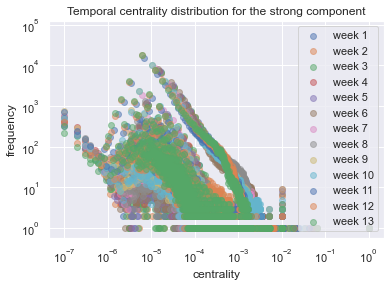

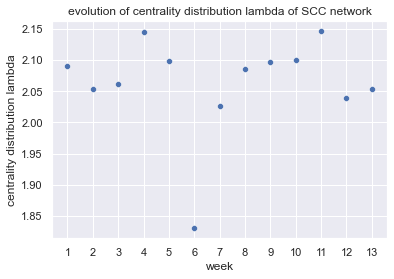

In [14]:
temporal_distribution('centrality distribution', strong_df, 'strong')
centrality_lambda_plot(strong_df, 'strong')

#### Communities

For further investigation on the network, we want to extract communities from the network. We do this with the use of the Louvain partitioning algorithm. For the Louvain algorithm, the network must first be converted to an undirected network.

In [15]:
def best_partition(G):
    
    G = G.to_undirected()
    
    # find the best partition
    louvain_partition = community.community_louvain.best_partition(G)
    
    modularity = round(community.modularity(louvain_partition, G), 3)
    number_of_communities = max(list(louvain_partition.values()))
    
    print(f'The best partitions contains {number_of_communities} communities')
    print(f'The modularity of the best partition is {modularity}')
    
    return louvain_partition

def plot_communities(partition, G):
    graph = community.induced_graph(partition, G)

    d_weight = dict(graph.degree(weight='weight'))

    pos = nx.random_layout(graph, seed=4)
    fig = plt.figure(1, figsize=(200, 80), dpi=10)
    plt.title('supernetwork of communities in bitcoin network data of week 13')
    nodes = nx.draw_networkx_nodes(graph, pos, nodelist=d_weight.keys(), node_size=[v * 5 for v in d_weight.values()])
    edges = nx.draw_networkx_edges(graph, pos, alpha=0.7, width=0.5)

The best partitions contains 4541 communities
The modularity of the best partition is 0.689


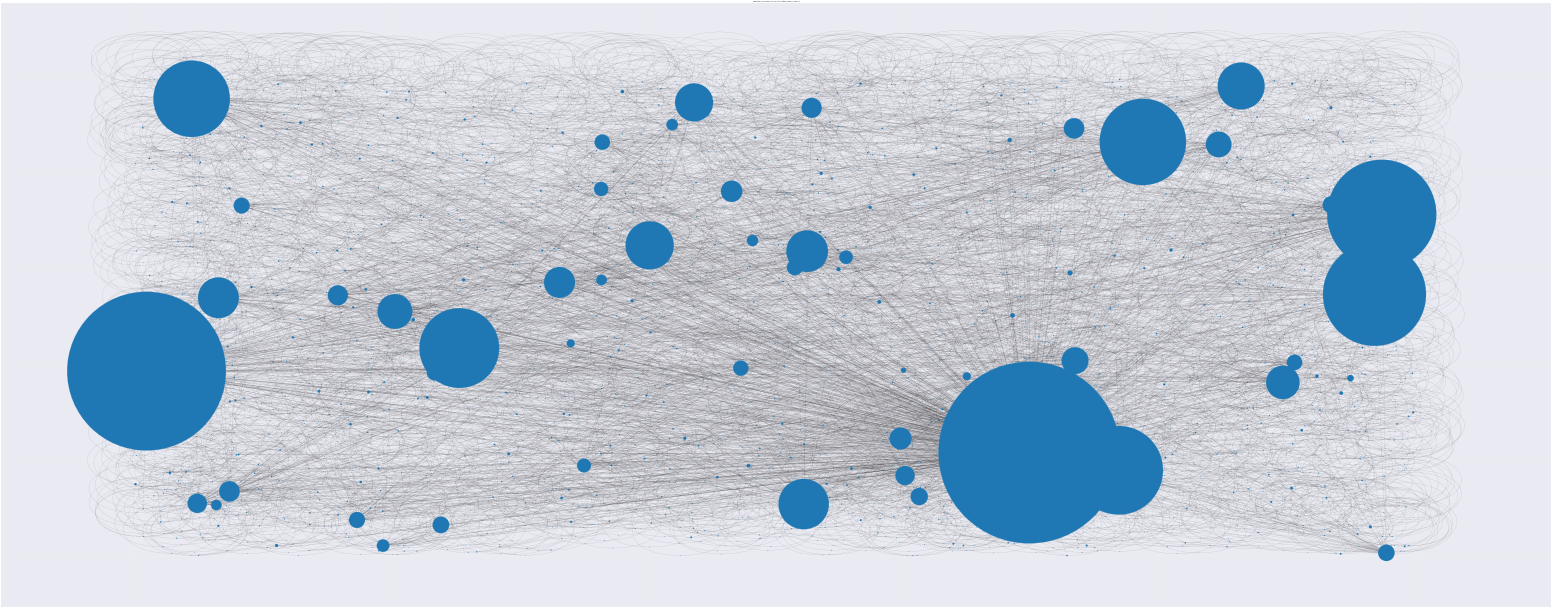

In [16]:
# load network into memory
G = nx.read_graphml(os.path.join(BIT_PATH, bitcoin_filenames[-1]))

# find best partition
partition = best_partition(G)

# plot communities supernetwork
plot_communities(partition, G)

The algorithm partitioned the last week's network into 4541 communities with a modularity of 0.689. The communities vary in size strongly, and all have different interactions with other communities

Looking at the supernetwork graph, we see that the community nodes vary in size strongly. The size of the nodes is based on the weighted total degree of the community. The weighted degree of each node is based on edges connecting them to other communities, and self-loops representing connections within the community itself. The weight of the edges represents the amount of connections between the communities or in the community itself.

The results clearly show that few communities are hubs in the supernetwork, meaning that they have a lot of connections within the community and/or out of the community. Besides these few hubs, most communities are much smaller, possibly indicating some connections within the community, but much less connections with other communities.

The information in the results is fairly limited, as upon creating the supernetwork, we lose information on which actual nodes and edges are occuring within a community. To further investigate these communities (for example to see why some networks are hubs) we will need to implement a method that builds the supergraph, while conserving information about the nodes that are in the communities itself.

#### Node centrality

To identify the most focal nodes in the network, we order all nodes in the network of week 8 and 13 by degree centrality and betweenness. The nodes with higher degree and betweenness will play a more important role in the network.

In [23]:
# load week 8 and 13 networks
week_13_file = bitcoin_filenames[-1]
week_8_file = bitcoin_filenames[-6]

G_13 = nx.read_graphml(os.path.join(BIT_PATH, week_13_file))
G_8 = nx.read_graphml(os.path.join(BIT_PATH, week_8_file))

In [24]:
# functions used to extract top centralities
def top_degrees(top_size, network):
    in_degree_list = network.in_degree()
    out_degree_list = network.out_degree()
    tot_degree_list = network.degree()
    top_in_degree_nodes = sorted(in_degree_list, key=lambda x:x[1], reverse=True)[:top_size]
    top_out_degree_nodes = sorted(out_degree_list, key=lambda x:x[1], reverse=True)[:top_size]
    top_tot_degree_nodes = sorted(tot_degree_list, key=lambda x:x[1], reverse=True)[:top_size]
    
    return top_in_degree_nodes, top_out_degree_nodes, top_tot_degree_nodes

def ordered_betweenness(network):
    betweenness_centrality = nx.betweenness_centrality(network, k=100)
    sorted_betweenness_centrality = dict(sorted(betweenness_centrality.items(), key=lambda item: item[1]))
    
    return sorted_betweenness_centrality

In [25]:
# print top betweenness and degree centrality nodes of week 13

betweenness_13 = ordered_betweenness(G_13)
reversed_betweenness_13 = dict(sorted(betweenness_13.items(), key=lambda item: item[1], reverse=True))

reversed_sliced_13 = dict(itertools.islice(reversed_betweenness_13.items(), 20))
top_in_degree_nodes_13, top_out_degree_nodes_13, top_tot_degree_nodes_13 = top_degrees(20, G_13)
print(f'betweenness: {reversed_sliced_13}')
print(f'top in degree: {top_in_degree_nodes_13}')
print(f'top out degree: {top_out_degree_nodes_13}')
print(f'top tot degree: {top_tot_degree_nodes_13}')

betweenness: {'24778': 0.5083932246100007, '4987284': 0.034126641758839754, '4195093': 0.011569313223475701, '3991726': 0.00789983868276788, '4802762': 0.007770585295481051, '5005789': 0.007736248483746447, '5461318': 0.007726329010752026, '3987425': 0.007722387933713147, '5408725': 0.007721541150135393, '2628640': 0.007719479895045965, '5506530': 0.007715956926244488, '5553105': 0.007715811020157057, '261452': 0.00771581102015705, '5466803': 0.007715779186101627, '5507324': 0.007715756486978399, '5481043': 0.007715683683935322, '5480056': 0.007714951500660311, '4216959': 0.00771473396794817, '5413462': 0.007713762978727146, '5575526': 0.007713741806553775}
top in degree: [('24778', 103919), ('4614011', 1771), ('1056959', 890), ('4195093', 872), ('5314986', 870), ('4045065', 520), ('3997440', 378), ('4756309', 343), ('5333013', 312), ('3483370', 308), ('5321333', 305), ('5576605', 305), ('3956256', 283), ('5056151', 280), ('4294487', 250), ('5542305', 228), ('4214511', 214), ('5529579'

In [26]:
# print top betweenness and degree centrality nodes of week 13

betweenness_8 = ordered_betweenness(G_8)
reversed_betweenness_8 = dict(sorted(betweenness_8.items(), key=lambda item: item[1], reverse=True))

reversed_sliced_8 = dict(itertools.islice(reversed_betweenness_8.items(), 20))
top_in_degree_nodes_8, top_out_degree_nodes_8, top_tot_degree_nodes_8 = top_degrees(20, G_8)
print(f'betweenness: {reversed_sliced_8}')
print(f'top in degree: {top_in_degree_nodes_8}')
print(f'top out degree: {top_out_degree_nodes_8}')
print(f'top tot degree: {top_tot_degree_nodes_8}')

betweenness: {'24778': 0.5321511648645116, '3183164': 0.03265717283038968, '4726253': 0.023535181253774146, '4616151': 0.019295287961350865, '4766959': 0.018056744190948937, '4766667': 0.01805171865680172, '4766958': 0.017840646222618627, '4767275': 0.017654701459171616, '4770650': 0.01728783746642481, '4771006': 0.01706671396394728, '4771376': 0.016745079778525424, '4771521': 0.016614415890697797, '4771833': 0.01639329238822027, '4772120': 0.016207347624773258, '4772352': 0.016076683736945627, '4772688': 0.01597114751985408, '4774089': 0.015830432563732018, '4774156': 0.015770126153965423, '4774393': 0.015664589936873873, '4774656': 0.015488696241721297}
top in degree: [('24778', 42660), ('4614011', 1102), ('1056959', 856), ('4726253', 636), ('3941484', 417), ('4045065', 416), ('4158737', 323), ('3997440', 266), ('3483370', 236), ('4688560', 210), ('4777504', 195), ('4743466', 186), ('4410033', 183), ('4672722', 180), ('259606', 174), ('3754505', 170), ('4294487', 164), ('3257030', 16